# You can also perform analyses on the tracks in your `Dataset` using some of the built in functionality in `trackio`.
___

In [1]:
import trackio as tio
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show
import geopandas as gp
import pandas as pd
import numpy as np

___
## Again, let's use the AIS data we've already been working with.

In [2]:
#create the Dataset
ds = tio.read(data_path='example00')

___
## Interpolating raster values to tracks

In [3]:
#get original track
track_id = 'Vessel_367341190_T0'

#get raster
ras = rio.open('files/sampler.tif')

#interpolate raster values to track
ds = ds.interpolate_raster(ras,
                           name='Raster',
                           tracks=[track_id],
                           method='linear')

#get sampled track
sampled = ds.get_track(track_id)

Interpolating raster to tracks: 100%|██████████| 1/1 [00:00<00:00, 111.08it/s]


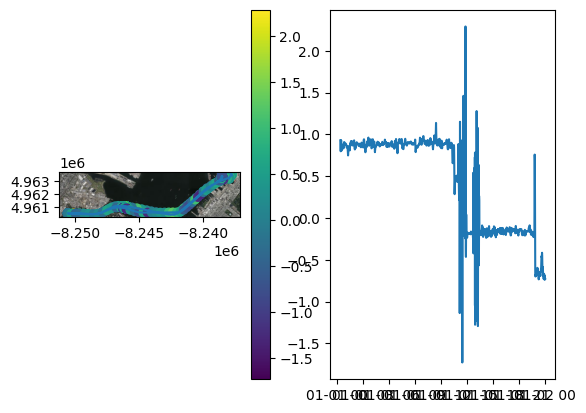

In [4]:
#plot sampled track
fig, ax = plt.subplots(1,2)
ax[0].plot(sampled['X'], sampled['Y'])
ax[0].set_xlim(ax[0].get_xlim())
ax[0].set_ylim(ax[0].get_ylim())
show(rio.open('files/basemap.tif'),'r', ax=ax[0])
m = ax[0].scatter(sampled['X'], sampled['Y'], c=sampled['Raster'])
plt.colorbar(m)
ax[1].plot(sampled['Time'], sampled['Raster'])

___
## Calculating Encounters Between Tracks

Here, an encounter refers to instances where 2 agents were within a spatial and temporal threshold of one another. E.g. Looking in a +/- 30min window, any agents that came within 100m of eachother.

In [5]:
#calculate spatiotemporal encounters
encounters = ds.encounters(distance=100,
                           time=1800,
                           data_cols=['Speed','Coursing'],
                           meta_cols=['MMSI'],
                           filter_min=True, #only keep minimum encounter (not all) for each unique pair of tracks
                           ncores=4)

Calculating spatiotemporal encounters: 100%|██████████| 11631/11631 [01:09<00:00, 167.65it/s] 


In [6]:
encounters.head(5)

,Agent ID_0,Track ID_0,Agent ID_1,Track ID_1,X_0,Y_0,X_1,Y_1,Time_0,Time_1,Minimum Distance,Time Difference,geometry,MMSI_0,MMSI_1,Speed_0,Speed_1,Coursing_0,Coursing_1
0,Vessel_248290000,Vessel_248290000_T0,Vessel_338329000,Vessel_338329000_T0,-8.238060e+06,4.967895e+06,-8.238086e+06,4.967920e+06,2021-01-01 14:49:00.000000000,2021-01-01 14:46:00.000000000,36.153896,180.000000,"POLYGON ((-8238054.888 4967907.697, -8238054.9...",248290000,338329000,4.261905,9.818310,307.785714,32.404225
1,Vessel_248290000,Vessel_248290000_T0,Vessel_367791550,Vessel_367791550_T0,-8.238281e+06,4.967927e+06,-8.238285e+06,4.967924e+06,2021-01-01 14:50:00.000000000,2021-01-01 14:30:00.000000000,4.071577,1200.000000,"POLYGON ((-8238280.946 4967925.413, -8238280.9...",248290000,367791550,6.551429,10.258730,278.368571,200.609524
2,Vessel_309987000,Vessel_309987000_T0,Vessel_338073000,Vessel_338073000_T0,-8.246266e+06,4.960924e+06,-8.246266e+06,4.960924e+06,2021-01-01 01:26:55.548962048,2021-01-01 00:59:12.898517504,0.000000,1662.650444,POLYGON EMPTY,309987000,338073000,NaN,NaN,NaN,NaN
3,Vessel_338295000,Vessel_338295000_T0,Vessel_366836590,Vessel_366836590_T0,-8.248027e+06,4.960542e+06,-8.247995e+06,4.960533e+06,2021-01-01 13:03:00.000000000,2021-01-01 12:48:00.000000000,33.041134,900.000000,"POLYGON ((-8247994.312 4960537.501, -8247994.3...",338295000,366836590,6.481250,10.215942,243.246875,64.963768
4,Vessel_338295000,Vessel_338295000_T0,Vessel_367029960,Vessel_367029960_T0,-8.251321e+06,4.959901e+06,-8.251318e+06,4.959829e+06,2021-01-01 13:16:00.000000000,2021-01-01 13:19:00.000000000,71.670940,180.000000,"POLYGON ((-8251283.760 4959864.731, -8251283.9...",338295000,367029960,6.700000,6.835714,251.890000,272.021429


C:\Users\dere\AppData\Local\Temp\ipykernel_25388\1267885632.py:28: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


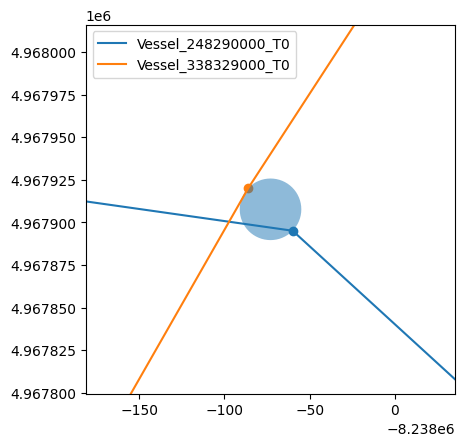

In [7]:
#track ids of first encounter
tid0 = encounters['Track ID_0'].iloc[0]
tid1 = encounters['Track ID_1'].iloc[0]

#tracks
t0 = ds.get_track(tid0)
t1 = ds.get_track(tid1)

#encounter circle
enc = encounters['geometry'].iloc[[0]]

#coords on tracks
x0,y0 = encounters[['X_0', 'Y_0']].iloc[0]
x1,y1 = encounters[['X_1', 'Y_1']].iloc[0]

#zoom to encounter
center = enc.iloc[0].centroid
dist = encounters['Minimum Distance'].iloc[0] * 3
plt.xlim(center.x-dist, center.x+dist)
plt.ylim(center.y-dist, center.y+dist)

#plot them
plt.plot(t0['X'], t0['Y'], label=tid0)
plt.scatter(x0,y0)
plt.plot(t1['X'], t1['Y'], label=tid1)
plt.scatter(x1,y1)
enc.plot(ax=plt.gca(), alpha=0.5, label='Encounter')
plt.legend()

___
## Calculating Intersections Between Tracks

This differs from an encounter in that the tracks must actually intersect. In this function, you can also specify a temporal threshold, e.g. the tracks of two agents crossed paths within +/-30min of eachother.

This takes a while, so it's smart to filter it down to only tracks you are interested in, or simplify the tracks first.

In [8]:
#calculate track intersections within 1 hour apart
intersections = ds.intersections(time=3600,
                                 tracks0=ds.tracks.index[:20], #first 10 tracks
                                 tracks1=ds.tracks.index[:20], #first 10 tracks
                                 data_cols=['Speed','Coursing'],
                                 meta_cols=['MMSI'],
                                 ncores=4)

Calculating intersections: 100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


In [9]:
intersections.head(5)

,Speed_0,Coursing_0,Time_0,X_0,Y_0,Agent ID_0,Track ID_0,Speed_1,Coursing_1,Time_1,X_1,Y_1,Agent ID_1,Track ID_1,MMSI_0,MMSI_1,Time Difference,geometry
0,0.0,170.0,2021-01-01 23:59:00,-8.244905e+06,4.960613e+06,Vessel_366952870,Vessel_366952870_T0,0.088333,162.8,2021-01-01 23:57:00,-8.244905e+06,4.960613e+06,Vessel_367549830,Vessel_367549830_T0,366952870,367549830,120.0,POINT (-8244905.124 4960613.064)
1,0.0,170.0,2021-01-01 23:59:00,-8.244350e+06,4.960795e+06,Vessel_366952870,Vessel_366952870_T0,0.088333,162.8,2021-01-01 23:57:00,-8.244350e+06,4.960795e+06,Vessel_367549830,Vessel_367549830_T0,366952870,367549830,120.0,POINT (-8244350.069 4960794.680)
2,0.0,170.0,2021-01-01 23:59:00,-8.243729e+06,4.961537e+06,Vessel_366952870,Vessel_366952870_T0,0.088333,162.8,2021-01-01 23:57:00,-8.243729e+06,4.961537e+06,Vessel_367549830,Vessel_367549830_T0,366952870,367549830,120.0,POINT (-8243728.545 4961537.218)
3,0.0,170.0,2021-01-01 23:59:00,-8.243696e+06,4.961556e+06,Vessel_366952870,Vessel_366952870_T0,0.088333,162.8,2021-01-01 23:57:00,-8.243696e+06,4.961556e+06,Vessel_367549830,Vessel_367549830_T0,366952870,367549830,120.0,POINT (-8243695.642 4961555.834)
4,0.0,170.0,2021-01-01 23:59:00,-8.244276e+06,4.960831e+06,Vessel_366952870,Vessel_366952870_T0,0.088333,162.8,2021-01-01 23:57:00,-8.244276e+06,4.960831e+06,Vessel_367549830,Vessel_367549830_T0,366952870,367549830,120.0,POINT (-8244276.414 4960830.779)


(4959613.063923388, 4961613.063923388)

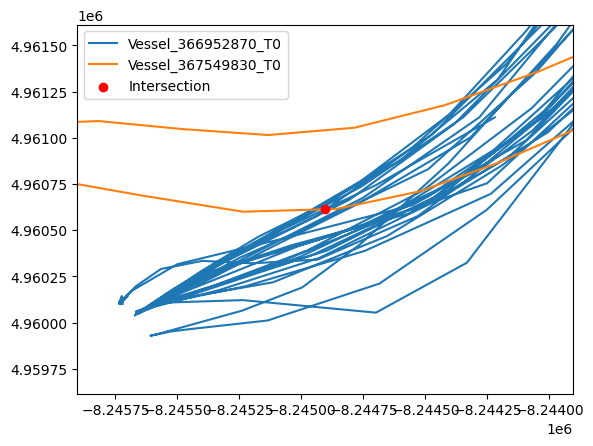

In [39]:
#track ids of first intersection
tid0 = intersections['Track ID_0'].iloc[0]
tid1 = intersections['Track ID_1'].iloc[0]

#tracks
t0 = ds.get_track(tid0)
t1 = ds.get_track(tid1)

#intersection point
inter = intersections['geometry'].iloc[0]

#plot them
plt.plot(t0['X'], t0['Y'], label=tid0)
plt.plot(t1['X'], t1['Y'], label=tid1)
plt.scatter(inter.x, inter.y, c='r', label='Intersection', zorder=2)
plt.legend()

#zoom to encounter
dist = 1000
plt.xlim(inter.x-dist, inter.x+dist)
plt.ylim(inter.y-dist, inter.y+dist)

___
## Proximity to Object

This method calculates the minimum proximity to a shapely object for each track. It can be a `Point`, `MultiPoint`, `LineString`, `MultiLineString`, `Polygon`, or `MultiPolygon`.

In [11]:
#read the object
line = gp.read_file(r'files/line.gpkg').iloc[0].geometry

#calculate closest proximity to object
distance_to_line = ds.proximity_to_object(line, 
                                          data_cols=['Speed','Coursing'],
                                          meta_cols=['MMSI'],
                                          ncores=4)

Calculating proximities to object: 100%|██████████| 163/163 [00:09<00:00, 17.53it/s]


In [12]:
distance_to_line.head(5)

,Speed,Coursing,Time,X,Y,geometry,Agent ID,Track ID,Min Distance,MMSI
0,12.100000,185.784286,2021-01-01 15:12:00.000000000,-8.243852e+06,4.961225e+06,POINT (-8243852.165176656 4961224.62933816),Vessel_248290000,Vessel_248290000_T0,10.921598,248290000
1,5.034864,315.632772,2021-01-01 01:15:50.158498048,-8.244549e+06,4.960072e+06,POINT (-8244548.527533398 4960072.150290958),Vessel_309987000,Vessel_309987000_T0,1313.867796,309987000
2,9.288175,301.314383,2021-01-01 00:54:00.000000000,-8.244688e+06,4.960447e+06,POINT (-8244687.947365691 4960447.386145622),Vessel_338073000,Vessel_338073000_T0,1151.957972,338073000
3,6.642615,11.455363,2021-01-01 22:41:11.315011072,-8.242827e+06,4.962452e+06,POINT (-8242826.754894157 4962451.672561663),Vessel_338093826,Vessel_338093826_T0,0.000000,338093826
4,6.800000,202.466197,2021-01-01 12:13:00.000000000,-8.244055e+06,4.961447e+06,POINT (-8244055.450245647 4961447.362102973),Vessel_338295000,Vessel_338295000_T0,1.241696,338295000


## As you can see, a particular track has a minimum distance of 0m from the shape. This means it intersects.

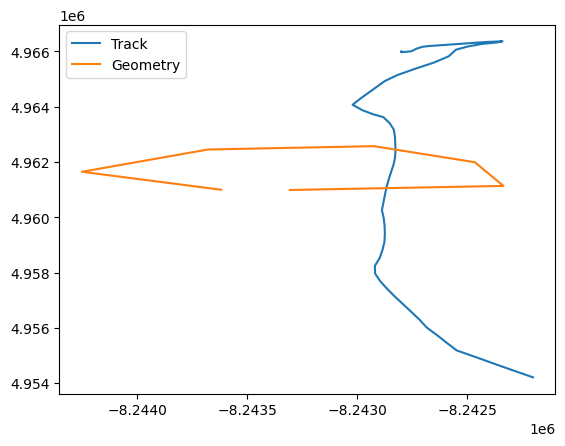

In [13]:
#plot the intersecting line and geometry
track = ds.get_track('Vessel_338093826_T0')
plt.plot(track['X'], track['Y'], label='Track')
plt.plot(*line.xy, label='Geometry')
plt.legend()

Converting tracks to GeoDataFrame: 100%|██████████| 163/163 [00:03<00:00, 52.61it/s]


<Axes: >

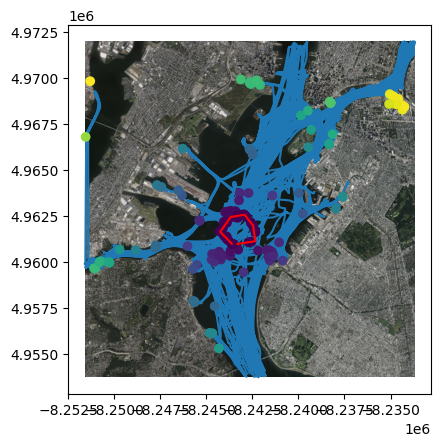

In [14]:
#plot the closest points on every track
gdf = ds.to_gdf(ncores=4)
gdf.plot()
plt.plot(*line.xy, c='r', zorder=10)
plt.scatter(distance_to_line['X'], distance_to_line['Y'], c=distance_to_line['Min Distance'], zorder=9)
plt.xlim(plt.gca().get_xlim())
plt.ylim(plt.gca().get_ylim())
show(rio.open('files/basemap.tif'),'r', ax=plt.gca())

___
## Minimum Proximity between Tracks

This method calculates the minimum distance between tracks that overlap in time in the `Dataset`.

The track proximity functions assume `Dataset.resample_time_global` has already been run. If not, the results will be invalid or the function may crash. The algorithm simply finds the minimum distance between each pair of tracks that have overlapping timesteps.

In [15]:
#resample the data to a global time axis
time = pd.date_range('2021-01-01', '2021-01-02', freq='60s')

#temporal resample
ds = ds.resample_time_global(time, 
                             ncores=4)

#refresh meta
ds = ds.refresh_meta(ncores=4)

Refreshing metadata: 100%|██████████| 163/163 [00:03<00:00, 53.68it/s]  


New meta/databases saved to c:\code\trackio\notebooks\example00


In [16]:
#track proximities, minimum distance between tracks
proximities = ds.proximities(data_cols=['Speed','Coursing'],
                             meta_cols=['MMSI'],
                             ncores=4)

Proximity analysis assumes that self.resample_time_global has already been run, if not the results will be invalid or the function may fail


Calculating track proximities: 100%|██████████| 11523/11523 [00:11<00:00, 1036.76it/s]


In [17]:
proximities.head(5)

,Speed_0,Coursing_0,Time_0,X_0,Y_0,Speed_1,Coursing_1,Time_1,X_1,Y_1,MMSI_0,MMSI_1,Minimum Distance,Agent ID_0,Agent ID_1,Track ID_0,Track ID_1,Common Timesteps
0,12.124286,186.717143,2021-01-01 15:13:00,-8.243933e+06,4.960739e+06,0.000000,6.800000,2021-01-01 15:13:00,-8.247306e+06,4.961174e+06,248290000,309987000,3401.316407,Vessel_248290000,Vessel_309987000,Vessel_248290000_T0,Vessel_309987000_T0,906
1,0.000000,116.000000,2021-01-01 00:54:00,-8.237875e+06,4.967663e+06,9.288175,301.314383,2021-01-01 00:54:00,-8.244688e+06,4.960447e+06,248290000,338073000,9924.042555,Vessel_248290000,Vessel_338073000,Vessel_248290000_T0,Vessel_338073000_T0,59
2,0.000000,246.988764,2021-01-01 11:35:00,-8.237875e+06,4.967662e+06,5.130986,205.932394,2021-01-01 11:35:00,-8.238025e+06,4.967789e+06,248290000,338295000,197.310498,Vessel_248290000,Vessel_338295000,Vessel_248290000_T0,Vessel_338295000_T0,139
3,0.000000,60.276536,2021-01-01 02:29:00,-8.237874e+06,4.967660e+06,8.700000,68.278689,2021-01-01 02:29:00,-8.238086e+06,4.968348e+06,248290000,338357486,719.143496,Vessel_248290000,Vessel_338357486,Vessel_248290000_T0,Vessel_338357486_T0,429
4,9.007812,221.551562,2021-01-01 14:56:00,-8.240489e+06,4.967391e+06,0.000000,360.000000,2021-01-01 14:56:00,-8.242627e+06,4.969789e+06,248290000,338380535,3212.198939,Vessel_248290000,Vessel_338380535,Vessel_248290000_T0,Vessel_338380535_T0,907


In [18]:
#get index of closest approach
min_idx = proximities['Minimum Distance'].argmin()
max_idx = proximities['Minimum Distance'].argmax()

#closest and furthest min distances
min_row = proximities.iloc[min_idx]
max_row = proximities.iloc[max_idx]

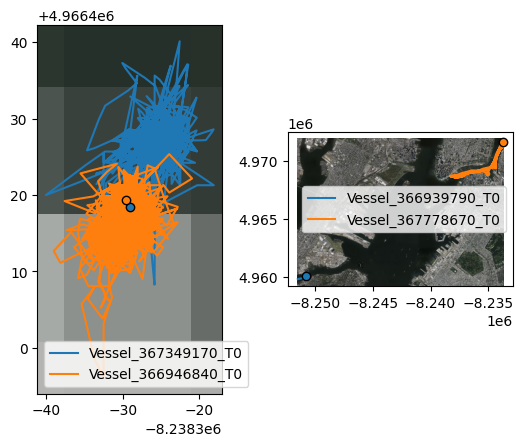

In [19]:
#plot
fig, ax = plt.subplots(1,2)
for a,row in zip(ax,[min_row, max_row]):
    #get tracks
    tid0 = row['Track ID_0']
    tid1 = row['Track ID_1']
    t0 = ds.get_track(tid0)
    t1 = ds.get_track(tid1)

    #coords on tracks
    x0,y0 = row[['X_0', 'Y_0']]
    x1,y1 = row[['X_1', 'Y_1']]

    #plot them
    a.plot(t0['X'], t0['Y'], label=tid0)
    a.scatter(x0, y0, zorder=10, edgecolor='k')
    a.plot(t1['X'], t1['Y'], label=tid1)
    a.scatter(x1, y1, zorder=10, edgecolor='k')
    a.legend()
    a.set_xlim(a.get_xlim())
    a.set_ylim(a.get_ylim())
    show(rio.open('files/basemap.tif'),'r', ax=a)

## This may be a way of indicating tug/tow vessels transiting alongside larger vessels such as cargo vessels, by correlating their proximity

___
## Binned Proximity between Tracks

This function calculates the amount of time tracks spend with certain distance bins from one another. Similar to the last function but it bins the amount of time spent inside distance bins, rather than just reporting the minimum. This provides a more detailed view of how closesly tracks are "following" eachother or interacting with eachother.

In [20]:
#track proximities, time spent binned by distance
bins=[10,
      100,
      500,
      1000,
      5000, 
      10000,
      20000,
      30000,
      50000,
      75000,
      100000]

proximities = ds.proximities(ncores=4, 
                             bins=bins,
                             data_cols=['Speed','Coursing'],
                             meta_cols=['MMSI'],
                             relative=False)

Proximity analysis assumes that self.resample_time_global has already been run, if not the results will be invalid or the function may fail


Calculating track proximities: 100%|██████████| 11523/11523 [00:20<00:00, 570.52it/s] 


___
## The dataframe holds the amount of time (seconds) spent between each distance bin, for each pair of tracks.

## This can very easily identify tracks that are following one another for long periods of time.

In [21]:
proximities[['Track ID_0', 
             'Track ID_1']+bins].head(5)

,Track ID_0,Track ID_1,10,100,500,1000,5000,10000,20000,30000,50000,75000,100000
0,Vessel_248290000_T0,Vessel_309987000_T0,0.0,0.0,0.000000,0.000000,764.765218,1970.914867,54300.0,54300.0,54300.0,54300.0,54300.0
1,Vessel_248290000_T0,Vessel_338073000_T0,0.0,0.0,0.000000,0.000000,0.000000,228.988552,3480.0,3480.0,3480.0,3480.0,3480.0
2,Vessel_248290000_T0,Vessel_338295000_T0,0.0,0.0,315.753402,526.761375,3254.824841,5210.831705,8280.0,8280.0,8280.0,8280.0,8280.0
3,Vessel_248290000_T0,Vessel_338357486_T0,0.0,0.0,0.000000,396.914508,24195.659289,25680.000000,25680.0,25680.0,25680.0,25680.0,25680.0
4,Vessel_248290000_T0,Vessel_338380535_T0,0.0,0.0,0.000000,0.000000,909.629689,53683.344743,54360.0,54360.0,54360.0,54360.0,54360.0


___
## Relative Binned Proximity between Tracks

This calculates the same binned promixities as the previous function, but for each distance bin it will calculate the relative amount of time spent within that distance bin.

For example, consider a given 1 hour interval. If 2 agents spent 30min within 1km of eachother but another pair of 2 agents spent 50min within 1km of eachother, then considering all the movements in that hour interval, agents (meaning 2+) spent 50min within 1km of eachother.

It provides binned distance proximities at the global `Dataset` level instead of on a track by track basis.

In [22]:
#calculate relative proximity timings
proximities = ds.proximities(ncores=4, 
                             bins=bins,
                             data_cols=['Speed','Coursing'],
                             meta_cols=['MMSI'],
                             relative=True)

Proximity analysis assumes that self.resample_time_global has already been run, if not the results will be invalid or the function may fail


Calculating track proximities: 100%|██████████| 11523/11523 [00:31<00:00, 361.20it/s] 


## Here the results are aggregated at each timestep for all tracks passed to the function. This timeseries can be used to observe the temporal variation of track clustering and spatial proximity.

In [23]:
proximities.head(5)

,Time,10,100,500,1000,5000,10000,20000,30000,50000,75000,100000
0,2021-01-01 00:18:00,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0
1,2021-01-01 00:19:00,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0
2,2021-01-01 00:20:00,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0
3,2021-01-01 00:21:00,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0
4,2021-01-01 00:22:00,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0


## To reduce this further, you can sum the times to get a measure of the amount of time spent over the entire duration of your `Dataset`.

In [24]:
proximities[bins].sum(axis=0)

10        67609.516134
100       85260.000000
500       85260.000000
1000      85260.000000
5000      85260.000000
10000     85260.000000
20000     85260.000000
30000     85260.000000
50000     85260.000000
75000     85260.000000
100000    85260.000000
dtype: float64

## The result implies that vessels are very close to one another throughout the dataset. This is likely due to moored vessels at ports/piers that have not been cleaned from the data yet.

___
## Extracting Lateral Distributions

This function slices tracks at user-defined cross-sections along a line segment, and returns the lateral position of agents as well as data fields at those locations. 

In [25]:
#start and end points of line
start = (-8236853, 4969110)
end = (-8235272, 4969359)

#clipping polygon for cross-section intersections
polygon = gp.read_file('files/lateral_clip.gpkg').geometry.iloc[0]

#lateral bin spacing along each cross-section
bins = 10

#spacing or n_slices for spacing between cross-sections
n_slices = 5

#split tracks by direction to/from
split = True

## Since the algorithm has the capability to split tracks going across the cross-sections into to/from directions, the coursings need to be accurate.

In [26]:
#lets make sure speed and coursing have been computed before extracting
ds = ds.compute_speed(ncores=4)
ds = ds.compute_coursing(ncores=4)
ds = ds.refresh_meta(ncores=4)

Refreshing metadata: 100%|██████████| 163/163 [00:02<00:00, 55.75it/s]  


New meta/databases saved to c:\code\trackio\notebooks\example00


In [27]:
#get the lateral cross sections/slices
lateral = ds.lateral_distribution(start,
                                  end,
                                  n_slices=n_slices,
                                  split=split,
                                  bins=bins,
                                  polygon=polygon,
                                  meta_cols=['MMSI'],
                                  data_cols=['Time', 'Speed', 'Coursing'],
                                  ncores=4)

Calculating lateral distributions at slices: 100%|██████████| 163/163 [00:10<00:00, 15.49it/s]


In [28]:
lateral.head(5)

Lateral Distance  \
Longitudinal Distance Direction                                                      
0.000000              F          [-81.72664413760543, 45.1284879718585, 22.8007...   
                      T          [61.95390881213387, 115.16979685298816, -15.20...   
400.122013            F          [-115.18754284932793, -71.12731785232127, -72....   
                      T          [26.038632213161065, 143.466106041165, -37.117...   
800.244025            F          [-108.96029017856569, -157.61495807228806, -12...   

                                                                            TrackX  \
Longitudinal Distance Direction                                                      
0.000000              F          [-8236865.7148306, -8236845.9790207, -8236849....   
                      T          [-8236843.36136302, -8236835.08216589, -823685...   
400.122013            F          [-8236475.67059502, -8236468.81581343, -823646...   
                      T          [-8236453.69897354, -8236435.42989557, -823646...   
800.244025            F          [-8236079.45177431, -8236087.02134806, -823608...   

                                                                            TrackY  \
Longitudinal Distance Direction                                                      
0.000000              F          [4969190.73151457, 4969065.42101082, 4969087.4...   
                      T          [4969048.80046165, 4968996.23254715, 4969125.0...   
400.122013            F          [4969286.03498276, 4969242.51124905, 4969243.3...   
                      T          [4969146.52842244, 4969030.53078281, 4969208.9...   
800.244025            F          [4969342.1335551, 4969390.19578831, 4969353.73...   

                                     SliceX      SliceY  \
Longitudinal Distance Direction                           
0.000000              F         -8236853.00  4969110.00   
                      T         -8236853.00  4969110.00   
400.122013            F         -8236457.75  4969172.25   
                      T         -8236457.75  4969172.25   
800.244025            F         -8236062.50  4969234.50   

                                                                              Time  \
Longitudinal Distance Direction                                                      
0.000000              F          [2021-01-01 11:24:43.913151744, 2021-01-01 03:...   
                      T          [2021-01-01 14:50:13.138153216, 2021-01-01 02:...   
400.122013            F          [2021-01-01 11:22:19.325794304, 2021-01-01 03:...   
                      T          [2021-01-01 14:51:10.326565632, 2021-01-01 02:...   
800.244025            F          [2021-01-01 11:19:49.359954944, 2021-01-01 03:...   

                                                                             Speed  \
Longitudinal Distance Direction                                                      
0.000000              F          [2.831286162634015, 5.790285894903349, 8.49119...   
                      T          [6.956225188854989, 3.29476097847569, 4.308658...   
400.122013            F          [2.720615402151551, 5.63142241954724, 8.427232...   
                      T          [7.1182929469346385, 3.1032378374425345, 4.308...   
800.244025            F          [2.6241031006806352, 5.445003535355022, 8.3674...   

                                                                          Coursing  \
Longitudinal Distance Direction                                                      
0.000000              F          [247.49279988027223, 244.94497567023913, 243.4...   
                      T          [70.71484131144597, 79.77378132642892, 72.4879...   
400.122013            F          [260.4467840787006, 246.84035613129348, 251.02...   
                      T          [78.93492290540203, 83.79698404801627, 80.3373...   
800.244025            F          [261.10935707844186, 249.74359080033472, 256.0...   

                                  

Text(-8235272, 4969359, 'END')

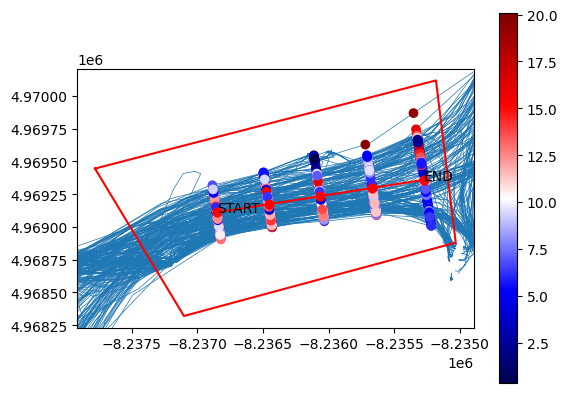

In [29]:
#plot the polygon and line
plt.plot(*polygon.exterior.xy, c='r', zorder=10)
plt.plot(lateral['SliceX'], lateral['SliceY'], '-o', c='r', zorder=10)

#fix the x,y lims
plt.gca().set_xlim(plt.gca().get_xlim())
plt.gca().set_ylim(plt.gca().get_ylim())

#plot the tracks
gdf.plot(linewidth=0.5, ax=plt.gca())

#plot the cross-section intersections
plt.scatter(lateral['TrackX'].explode(),
            lateral['TrackY'].explode(),
            c=lateral['Speed'].explode(),
            cmap='seismic',
            zorder=2)
plt.colorbar()

#plot start/end points
plt.text(*start, 'START', zorder=11)
plt.text(*end, 'END', zorder=11)

___
## Now, let's plot the lateral position distributions at one of the slices, as well as distributions of the data fields.

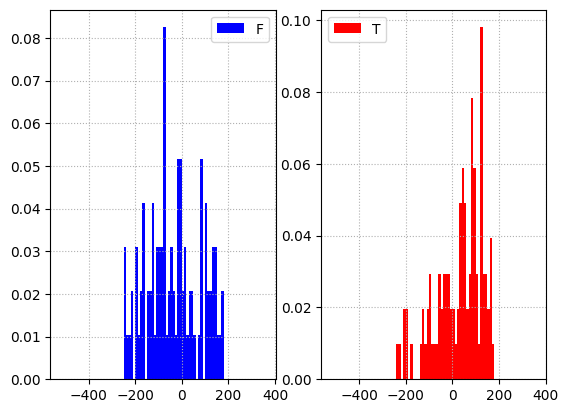

In [30]:
#get the slice
slice0 = lateral.iloc[2] #one way
slice1 = lateral.iloc[3] #the other way

#plot binned lateral positions
fig, ax = plt.subplots(1,2)
ax[0].stairs(slice0['Frequency'], slice0['Bins'], color='b', label=slice0.name[1], fill=True)
ax[1].stairs(slice1['Frequency'], slice1['Bins'], color='r', label=slice1.name[1], fill=True)
for a in ax:
    a.grid(linestyle=':')
    a.legend()

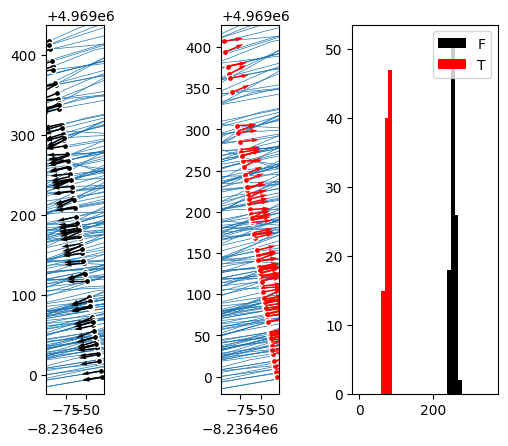

In [31]:
#plot the slice with vectors on the left
fig, ax = plt.subplots(1, 3)
ax[0].scatter(slice0['TrackX'], slice0['TrackY'], c='k', edgecolor='w', s=20)
ax[0].quiver(slice0['TrackX'], 
             slice0['TrackY'],
             np.sin(np.radians(slice0['Coursing'])),
             np.cos(np.radians(slice0['Coursing'])),
             color='k',
             scale=3,
             width=0.025)
ax[1].scatter(slice1['TrackX'], slice1['TrackY'], c='r', edgecolor='w', s=20)
ax[1].quiver(slice1['TrackX'], 
             slice1['TrackY'],
             np.sin(np.radians(slice1['Coursing'])),
             np.cos(np.radians(slice1['Coursing'])),
             color='r',
             scale=3,
             width=0.025)

#fix the xlim, ylim
ax[0].set_xlim(ax[0].get_xlim())
ax[0].set_ylim(ax[0].get_ylim())
ax[1].set_xlim(ax[1].get_xlim())
ax[1].set_ylim(ax[1].get_ylim())

# #plot the tracks
gdf.plot(ax=ax[0], linewidth=0.5, zorder=-1)
gdf.plot(ax=ax[1], linewidth=0.5, zorder=-1)

#plot coursing at slice
plt.hist(slice0['Coursing'], bins=range(0,370,10), label=slice0.name[1], color='k')
plt.hist(slice1['Coursing'], bins=range(0,370,10), label=slice1.name[1], color='r')
plt.legend()

___
## Time Spent in Polygon

This method calculates when and where tracks enter and exit a given polygon, and records the time spent along with other data fields at their entry and exit point(s).

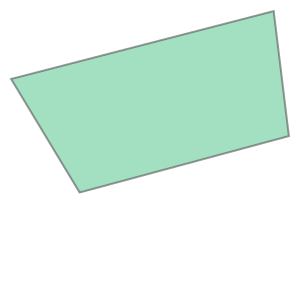

In [32]:
#use the same polygon from the lateral clipping
polygon

In [33]:
#calculate time spent in polygon
time_spent = ds.time_in_polygon(polygon,
                                meta_cols=['MMSI'],
                                data_cols=['Speed','Coursing'],
                                ncores=4)

Computing time spent in polygon: 100%|██████████| 163/163 [00:02<00:00, 55.57it/s]


## In the results table, the 0 and 1 notation referw to the entrance (0) and exit (1) of the track in the polygon. If the track starts or ends inside the polygon, then the notation refers to the first/last points points on the track.

In [34]:
time_spent.head(5)

,Speed_0,Coursing_0,X_0,Y_0,Time_0,Speed_1,Coursing_1,X_1,Y_1,Time_1,MMSI,Agent ID,Track ID,Duration,Distance Travelled
0,2.563614,250.043110,-8.235199e+06,4.969426e+06,2021-01-01 11:14:00,2.812503,232.019299,-8.237368e+06,4.968943e+06,2021-01-01 11:28:00,338295000,Vessel_338295000,Vessel_338295000_T0,840.0,2252.434467
1,6.831011,55.865368,-8.237296e+06,4.968836e+06,2021-01-01 14:49:00,6.932119,66.615218,-8.235254e+06,4.969364e+06,2021-01-01 14:54:00,338329000,Vessel_338329000,Vessel_338329000_T0,300.0,2126.372667
2,5.127386,63.855026,-8.237159e+06,4.968881e+06,2021-01-01 02:32:00,3.198612,67.430509,-8.235264e+06,4.969299e+06,2021-01-01 02:41:00,338357486,Vessel_338357486,Vessel_338357486_T0,540.0,1952.220441
3,5.277591,242.231392,-8.235198e+06,4.969698e+06,2021-01-01 03:06:00,5.911805,243.480402,-8.237374e+06,4.968827e+06,2021-01-01 03:13:00,338357486,Vessel_338357486,Vessel_338357486_T0,420.0,2346.989035
4,4.559612,49.691675,-8.237331e+06,4.968875e+06,2021-01-01 21:21:00,4.357442,69.364983,-8.235336e+06,4.969402e+06,2021-01-01 21:29:00,338458000,Vessel_338458000,Vessel_338458000_T0,480.0,2086.609569


Text(-8236285.078121668, 4969211.399102353, '2252.434467074191 m\n 840.0 s')

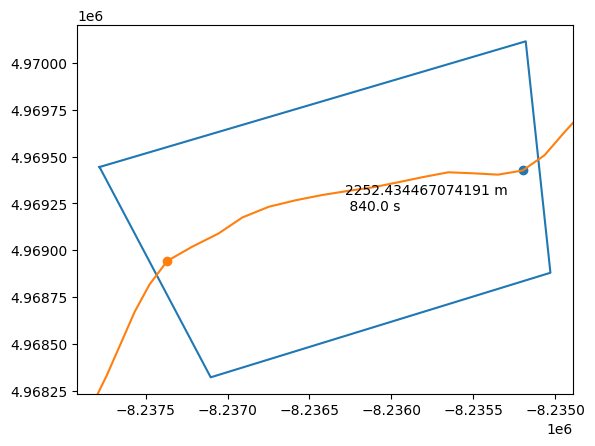

In [35]:
#plot the polygon
plt.plot(*polygon.exterior.xy)

#fix the x,y lims
plt.gca().set_xlim(plt.gca().get_xlim())
plt.gca().set_ylim(plt.gca().get_ylim())

#plot first track inside
first = time_spent.iloc[0]
track = ds.get_track(first['Track ID'])
plt.plot(track['X'], track['Y'])

#plot first entry/exit
plt.scatter(*first[['X_0', 'Y_0']])
plt.scatter(*first[['X_1', 'Y_1']])

#plot stats
plt.text(polygon.centroid.x,
         polygon.centroid.y, 
         f"{first['Distance Travelled']} m\n {first['Duration']} s")


___
## Notice how the entry/exit points aren't exactly on the polygon perimeter. You can improve the accuracy of these time in polygon estimates by running the `Dataset.imprint_geometry` method first.

In [36]:
#imprint the polygon
ds = ds.imprint_geometry(polygon,
                         ncores=4)

Imprinting geometry into tracks: 100%|██████████| 163/163 [00:03<00:00, 42.65it/s]


In [37]:
#redo the calculation
time_spent = ds.time_in_polygon(polygon,
                                meta_cols=['MMSI'],
                                data_cols=['Speed','Coursing'],
                                ncores=4)

Computing time spent in polygon: 100%|██████████| 163/163 [00:02<00:00, 54.80it/s]


Text(-8236285.078121668, 4969211.399102353, '2463.624903112335 m\n 918.740555 s')

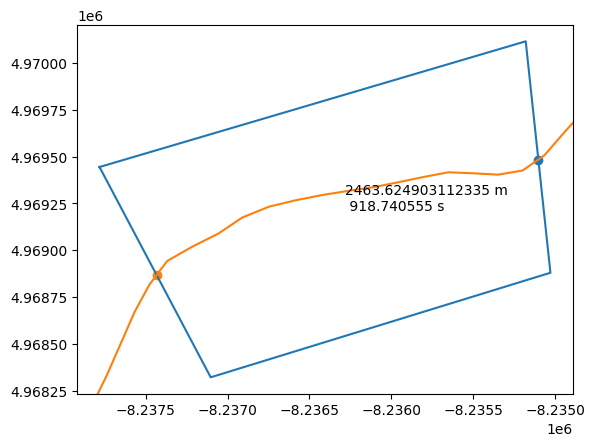

In [38]:
#plot the polygon
plt.plot(*polygon.exterior.xy)

#fix the x,y lims
plt.gca().set_xlim(plt.gca().get_xlim())
plt.gca().set_ylim(plt.gca().get_ylim())

#plot first track inside
first = time_spent.iloc[0]
track = ds.get_track(first['Track ID'])
plt.plot(track['X'], track['Y'])

#plot first entry/exit
plt.scatter(*first[['X_0', 'Y_0']])
plt.scatter(*first[['X_1', 'Y_1']])

#plot stats
plt.text(polygon.centroid.x,
         polygon.centroid.y, 
         f"{first['Distance Travelled']} m\n {first['Duration']} s")

___
## Generating and Reducing to Flow Maps

See example [here](https://github.com/derekeden/trackio/blob/main/notebooks/example3_Canada_Goose_migrations/example3.ipynb).
___